In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')[:-1]
print(len(train_data), len(test_data))

train= train_data
test = test_data.apply(pd.to_numeric)

68636 29413


In [3]:
X = train.drop("signal", axis=1)
X = (X-X.mean())/X.std()
train = X.join(train["signal"])

XX = test.drop("signal", axis=1)
XX = (XX-XX.mean())/XX.std()
test = XX.join(test["signal"])

In [4]:
from scipy.stats import ks_2samp
train_stat, train_p = [], []

for i in range(len(train.keys())-1):
    train_stat = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[0])
    train_p = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[1])


train_list = dict(zip(train.keys()[:-1],train_stat))
train_list_sorted = dict(sorted(train_list.items(), key=lambda item: item[1]))
train_list_sorted


{'missing_energy_phi': 0.003254063696343179,
 'lepton_phi': 0.005250537605601402,
 'jet1phi': 0.006744408012343661,
 'jet3phi': 0.007694254995927352,
 'jet4phi': 0.008105746088170163,
 'jet2phi': 0.008137114722488237,
 'm_lv': 0.010386893995635749,
 'lepton_eta': 0.010518898163357937,
 'jet1b.tag': 0.012580087397600026,
 'jet3pt': 0.012693279584993333,
 'id': 0.01269965758149394,
 'jet1eta': 0.014007216717948245,
 'jet3eta': 0.014504340101392843,
 'jet4b.tag': 0.015875851281828557,
 'jet2eta': 0.0173633309139285,
 'm_jj': 0.017681132670639033,
 'jet4eta': 0.019486671326037097,
 'jet3b.tag': 0.02494816071865935,
 'jet2pt': 0.02846273239147512,
 'jet4pt': 0.030942537809816595,
 'lepton_pT': 0.03858265522652582,
 'jet2b.tag': 0.049864347970956235,
 'm_jlv': 0.05341320850942499,
 'jet1pt': 0.06990101266799159,
 'missing_energy_magnitude': 0.07262518556598518,
 'm_jjj': 0.09632140613997875,
 'm_wbb': 0.1070652762675185,
 'm_wwbb': 0.1517473764300511,
 'm_bb': 0.1960046638615971}

In [66]:
def act_f(xvals):
    return np.log(1 + np.exp(xvals))
#   return np.arctan(xvals)
    #return 1/(1+np.exp(-xvals))

def f_cost(y, xvals):
    return (1/2) * (y - xvals)**2

def der_f_act(xvals):
#     modx = np.abs(xvals)
#     modx = np.where(modx==0,-1,modx)
#     b = xvals/modx
#     A = np.maximum(0,b)
    return(np.exp(xvals)/(1 + np.exp(xvals)))
    return 1/(1 + xvals**2)

    #return np.exp(-xvals)/(1+np.exp(-xvals))**2
    #return f_act(x_input) * (1 - f_act(x_input))

def der_f_cost(y, xvals):
    return -(y - xvals)

In [67]:
#np.random.seed(12)
def bias_vector(n_nodes):
    return np.array(np.random.uniform(-1,1,n_nodes))
    #return np.ones(n_nodes)

def initialize_all_bias(n_hidden_nodes,n_hidden_layers):
    all_bias_nodes = []
    for _ in range(n_hidden_layers):
        all_bias_nodes.append(bias_vector(n_hidden_nodes))
    all_bias_nodes.append(bias_vector(1))
    
    return all_bias_nodes
    
def init_weight_mat(n_next,n_previous):
    return np.array(np.random.uniform(-1,1,[n_next,n_previous]))
    #return np.ones([n_next,n_previous])


def initialize_all_weight_matrices(n_input_features, n_hidden_nodes, n_hidden_layers):
    
    list_of_nodes = [n_input_features]
    for _ in range(n_hidden_layers):
        list_of_nodes.append(n_hidden_nodes)
    list_of_nodes.append(1)
    
    all_weight_matrices = []
    for i in range(len(list_of_nodes)-1):
        all_weight_matrices.append(init_weight_mat(list_of_nodes[i+1],list_of_nodes[i]))

    #[number of inputs][number of hidden nodes][number of input layers]
    return all_weight_matrices

def input_sum(weights, inputs, bias):
    return np.dot(weights,inputs) + bias



In [68]:
def forward_prop(input_features, n_hidden_nodes, n_hidden_layers, weight_list_dummy, bias_list_dummy):

    
    x_list = input_features
    z_list, act_z_list = [], []

    for layer in range(len(weight_list_dummy)):
        
        z_list.append((np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())
        act_z_list.append(act_f(np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())

        x_list = act_z_list[-1]
    act_z_list.insert(0,np.array(input_features))
    
    
    
    # for 1st two vars :[# var][layer number][node number][data number]            
    return z_list, act_z_list, weight_list_dummy, bias_list_dummy

In [90]:
# function to initialize errors for each node (set to 0 at start)
def initialize_node_error(n_hidden_nodes,n_hidden_layers):
    all_nodes = []
    for _ in range(n_hidden_layers):
        all_nodes.append([0] * n_hidden_nodes)
    all_nodes.append([0])
    
    return all_nodes
    
def back_prop(true_values, z_list, act_z_list, weight_list, bias_list, input_features,l_rate,epochs):
    
    cost_cal = np.sum(f_cost(true_values, act_z_list[-1]))
    output_error = der_f_cost(true_values, act_z_list[-1][0]) 
    lrate = l_rate*1/ len(true_values)
    
    # to store weights...
    #weight_epochs, bias_epochs = []
    #weight_epochs.append(weight_list)
    #bias_epochs.append(bias_list)
    
    # np.shape(weight_list[1])[1] = no. of hidden nodes
    # len(weight_list[:-1]) = no. of hidden layers
    
    error_node_matrix = initialize_node_error(np.shape(weight_list[-1])[1], len(weight_list[:-1]))

    error_node_matrix[-1][0] = output_error * der_f_act(z_list[-1][0])

    for layer in range(len(weight_list)-1,0,-1): 
        
        for node in range(np.shape(weight_list[layer])[1]):
            
            for each_weight in range(np.shape(weight_list[layer][0])[0]): 
                
                if layer==len(weight_list)-1:
 
                    error_node_matrix[layer-1][node] +=( weight_list[layer][0][each_weight] * 
                                                      error_node_matrix[layer][0] * 
                                                      der_f_act(z_list[layer-1][node]) )
                    
                if layer<len(weight_list)-1:
                
                    error_node_matrix[layer-1][node] +=( weight_list[layer][each_weight][node] * 
                                                      error_node_matrix[layer][each_weight] * 
                                                      der_f_act(z_list[layer-1][node]) )
 
    
    for layer in range(len(weight_list)):    
        
        for node in range(np.shape(weight_list[-layer-1])[0]):
            
            for each_weight in range(np.shape(weight_list[-layer-1][node])[0]):
                    
                if layer!=(len(weight_list)-1):
                    
                    weight_list[-layer-1][node][each_weight] -= np.sum(lrate * act_z_list[-layer-2][each_weight] *
                                                          error_node_matrix[-layer-1][node])
                    
                if layer==(len(weight_list)-1):
                    weight_list[-layer-1][node][each_weight] -= np.sum(lrate * input_features[each_weight] *
                                                          error_node_matrix[-layer-1][node])
                
                bias_list[-layer-1][node] -=  np.sum(lrate * error_node_matrix[-layer-1][node])
                    
    
    return weight_list, bias_list, cost_cal

def train_network(input_features, n_hidden_nodes, n_hidden_layers, true_values,epochs,l_rate = 0.1):
    
    weight_list = initialize_all_weight_matrices(len(input_features), n_hidden_nodes, n_hidden_layers)
    bias_list = initialize_all_bias( n_hidden_nodes, n_hidden_layers)
    cost_all = np.array([])
    for epochs_i in range(epochs):
        z_list_i, act_z_list_i, weight_list_i, bias_list_i = forward_prop(input_features, n_hidden_nodes, 
                                                                          n_hidden_layers, weight_list, bias_list)
        
        weights_updated, bias_updated, cost_dum = back_prop(true_values, z_list_i, act_z_list_i, weight_list_i, 
                                                  bias_list_i, input_features,l_rate,epochs)
        weight_list_i = weights_updated
        bias_list_i = bias_updated
        
        cost_all = np.append(cost_all,cost_dum)
        #print(epochs_i+1, end=" ")
        
        
    return weights_updated, bias_updated, cost_all

In [89]:
#d_index = 10000
#input_vector = np.array([train['m_bb'][:d_index],train['m_wwbb'][:d_index],train['m_wbb'][:d_index]])
input_vector = np.array([train['m_bb'],train['m_wwbb'],train['m_wbb']])
#true_vector = np.array(train['signal'][:d_index])
true_vector = np.array(train['signal'])
n_n = 10
n_hd = 5
epochs = 5000
all_arr = [[[]for i in range(n_n)] for j in range(n_hd)]
for i in range(1,n_n):
    for j in range(1,n_hd):
        all_arr[i][j] = train_network(input_vector,j,i,true_vector,epochs)
        print('%s Hidden Layers, %s Nodes -- Done'%(j,i))
        if np.abs(all_arr[i][j][2][-1] - all_arr[i][j][2][-5]) < 200:
            print("The cost function for the config %s nodes per the %s layers does not converge after %s epochs"%(i,j,epochs))  


1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 

KeyboardInterrupt: 

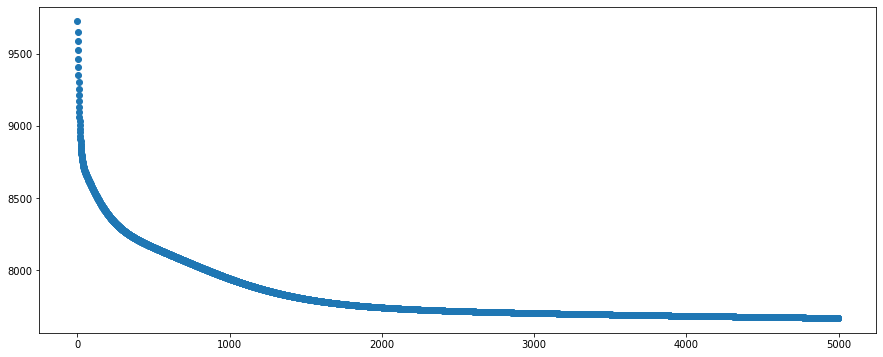

In [75]:
plt.figure(figsize=(15,6))
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])

plt.show()

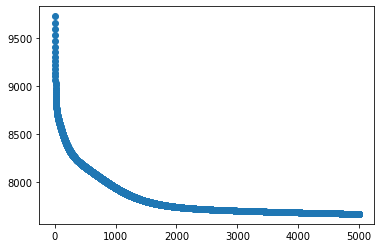

In [77]:
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])
plt.show()

In [78]:
def test_network(input_test_vector, weights_trained, bias_trained):
    
    x_test_list = input_test_vector
    z_test_list, act_z_test_list = [], []     
    for layer in range(len(weights_trained)):

        z_test_list.append((np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())
        act_z_test_list.append(act_f(np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())

        x_test_list = act_z_test_list[-1]
    act_z_test_list.insert(0,np.array(input_test_vector))
    
    # for 1st two vars :[# var][layer number][node number][data number]            
#    return z_test_list, act_z_test_list
    return act_z_test_list[-1][0]




In [79]:
test_vector = np.array([test['m_bb'],test['m_wwbb'],test['m_wbb']])

test_output = test_network(test_vector,all_arr[0],all_arr[1])

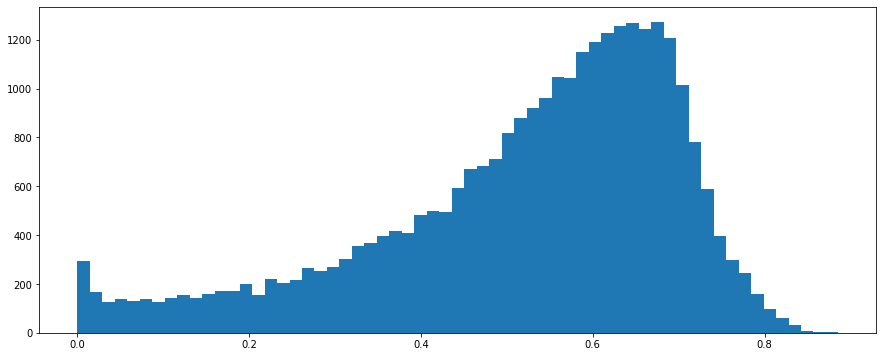

In [80]:
plt.figure(figsize=(15,6))
plt.hist(test_output,bins='auto')

plt.show()

ROC score for  m_bb 0.5538334386750075
ROC score for  m_wwbb 0.567830783780928
ROC score for  m_wbb 0.5171133577631016
ROC score for  MLP output 0.6989770116903606


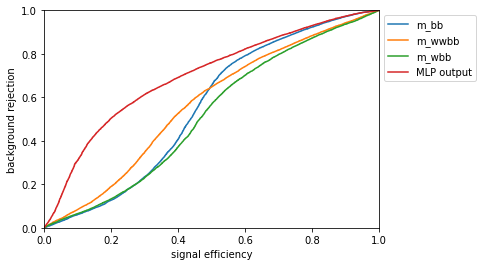

In [81]:
feats = ['m_bb','m_wwbb','m_wbb']#,'m_jjj']

from sklearn.metrics import roc_curve, roc_auc_score
def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]

for label,value in [(f, left_right_ordered_feature(test, f)) for f in feats]+[("MLP output", test_output)]:
    fpr, tpr, thresh = roc_curve(test["signal"], value)
    
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)
    print("ROC score for ",label,roc_auc_score(test["signal"], value))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

ROC score for  m_bb 0.5538334386750075
ROC score for  m_wwbb 0.567830783780928
ROC score for  m_wbb 0.5171133577631016
ROC score for  MLP output 0.7100882829934284


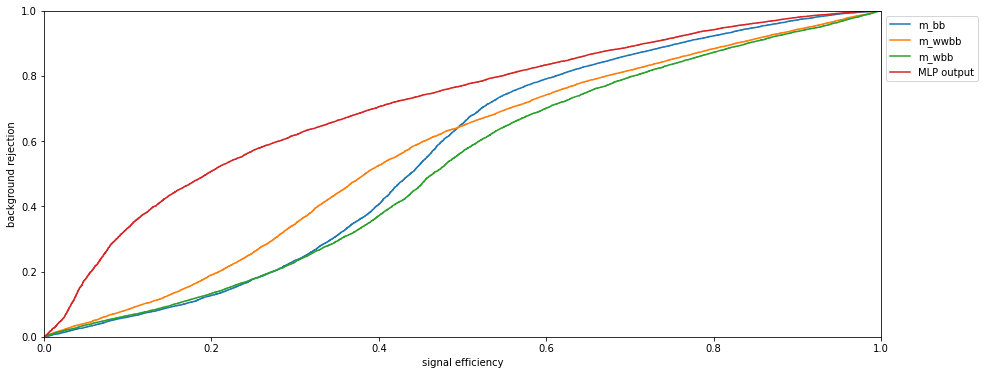

area = 0.5723872847257065


In [65]:
feats = ['m_bb','m_wwbb','m_wbb']#,'m_jjj']

from sklearn.metrics import roc_curve
def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]
plt.figure(figsize=(15,6))
for label,value in [(f, left_right_ordered_feature(test, f)) for f in feats]+[("MLP output", test_output)]:
    fpr, tpr, thresh = roc_curve(test["signal"], value)
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)
    print("ROC score for ",label,roc_auc_score(test["signal"], value))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

from scipy.integrate import simps
area_p = simps(tpr, dx=fpr[1])
print("area =", area_p)

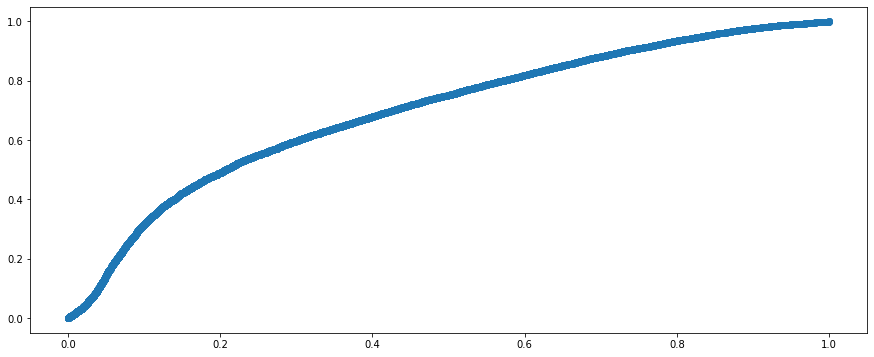

In [44]:
plt.figure(figsize=(15,6))
plt.scatter(fpr,tpr)